In [1]:
import tensorflow as tf
import numpy as np
import random, json, string, pickle
import keras
import keras.layers
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import keras.models
from keras.models import Sequential
import keras.optimizers
import keras.callbacks
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

import keras.applications.vgg16 as vgg16

Using TensorFlow backend.


In [2]:
from bokeh.charts import Line
from bokeh.plotting import figure, show
from bokeh.models import Range1d
from bokeh.io import output_notebook
import bokeh as bokeh
output_notebook()
 
class LossTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.durations = []
        self.val_loss = []
    
    def on_epoch_begin(self, epoch, logs={}):
        import time
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        import time
        duration = time.time()-self.start_time
        self.durations.append(duration)  

Loading BokehJS ...

In [3]:
size_pantry = 500

In [4]:
# m = vgg16.VGG16(weights='imagenet')
# m.layers.pop()
# m.layers.append(Dense(size_pantry, activation='sigmoid'))
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# m.compile(loss='binary_crossentropy', optimizer = adam, metrics=['accuracy'])
# m.summary()

# get the pretrained model (minus FC layers)
original_model = vgg16.VGG16(weights='imagenet', include_top=False, input_tensor = vgg16.Input(shape=(224,224,3)))

# freeze conv layers
#for layer in original_model.layers:
#    layer.trainable = False
    #pass

# construct model
deep_features = Flatten()(original_model.output)
#fc1 = Dense(10, activation="relu")(deep_features)
ingredients_guessing = Dense(size_pantry, activation='sigmoid')(deep_features)#fc1)

m = keras.models.Model(input=original_model.input, output=ingredients_guessing)

print(m.summary())

#optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0, nesterov=True)
optimizer = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

#optimizer = Adam()
m.compile(optimizer, loss='binary_crossentropy')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

Creating the Pantry

In [ ]:
conn = sqlite3.connect("yummly.db")
recipes = conn.execute("SELECT ID, CleanIngredients FROM Recipe WHERE ImageAvailable=1 AND English=1;").fetchall()
conn.close()

In [ ]:
def prepIngredients(ingredients_string):
    return [x.strip() for x in ingredients_string.split(";")]

recipes = [tuple([x[0], prepIngredients(x[1])])for x in recipes]

In [ ]:
all_ingredients = np.array([item for sublist in recipes for item in sublist[1]])
unique_ing = np.unique(all_ingredients, return_counts = True)

argsort_results = np.argsort(unique_ing[1])

sorted_ing = unique_ing[0][argsort_results]
sorted_vals = unique_ing[1][argsort_results]
sorted_ing = sorted_ing[::-1]

id2food = sorted_ing[0:size_pantry]
food2id = {food: idx[0] for idx, food in np.ndenumerate(id2food)}



In [ ]:
id2food[169]

In [ ]:
# free up some memory
all_ingredients = None
argsort_results = None
sorted_vals = None

In [ ]:
ids = [] #[x[0] for x in recipes]
recipe_ingredients = [x[1] for x in recipes]
labels = [] #np.zeros([len(recipes), size_pantry])

class_frequency = [0] * size_pantry


# Then we build our training data. We're not going to include
# recipes that have ingredients not in the pantry
for i in range(0, len(recipes)):
    num_misses = 0
    current_recipe = [0] * size_pantry
    
    for j in range(0, len(recipe_ingredients[i])):
        if food2id.get(recipe_ingredients[i][j]) != None:
            food_id = food2id.get(recipe_ingredients[i][j])
            
            current_recipe[food_id] = 1
            class_frequency[food_id] = class_frequency[food_id] + 1
        else:
            num_misses = num_misses + 1
    
    if num_misses == 0 and sum(current_recipe) > 0:
        labels.append(current_recipe)
        ids.append(recipes[i][0])
            
    #labels[i, [food2id.get(x) for x in recipe_ingredients[i]]] = 1

In [ ]:
recipe_ingredients = None
recipes = None

In [ ]:
class_weights = [{index: len(ids) / x / 100} for index, x in enumerate(class_frequency)]


In [ ]:
class_weights2 = [{index: np.power(5000 / x, 2)} for index, x in enumerate(class_frequency)]

In [ ]:
len(labels[0])

In [ ]:
pickle.dump( [ids, labels, food2id, id2food, class_weights, class_weights2], open( "ids_labels_nomissing_500.p", "wb" ) )

In [5]:
[ids, labels, food2id, id2food, class_weights, class_weights2] = pickle.load( open( "ids_labels_nomissing_500.p", "rb" ) )

In [6]:
four_fifths = (len(labels) // 5) * 4

train_ids = ids[0:four_fifths]
train_labels = labels[0:four_fifths]

test_ids = ids[four_fifths:]
test_labels = labels[four_fifths:]

In [7]:
ids = None
labels = None

In [8]:
train_ids[40]
#train_labels[40]

'3c89336a-cda7-44e7-b4f6-64eaf73c95b1'

In [9]:
m.load_weights('model_weights_w_cnn.hdf5')

In [10]:
filepath = "model_weights_w_cnn.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                             verbose=1, save_best_only=True, mode='min')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                          patience=150, verbose=1, mode='min')

history = LossTimeHistory()

In [10]:
#samp_per_epoch
len(test_ids) // 64

1624

In [ ]:
import random

def DataGenerator(imageIds, imageLabels, batch_size):
    batch = np.zeros((batch_size, 224, 224, 3))
    labels = np.zeros((batch_size, size_pantry))
    while True:
        batch_bad = False
        
        for i in range(0, batch_size):
            index = random.randint(0, len(imageIds) - 1)
            img_path = 'resized_thumbs/' + imageIds[index] + ".jpg"
            
            try:   
                #turns out a small number of our images are corrupted
                img = image.load_img(img_path, target_size=(224, 224))
            except:
                #print("Error reading image: " + imageIds[index])
                batch_bad = True
                
            
            img = image.img_to_array(img)
            batch[i, :, :, :] = img
            labels[i, :] = imageLabels[index]#, :]
        batch = vgg16.preprocess_input(batch)
        
        if batch_bad is False:
            #print(batch[10, :, :, 0])
            yield batch, labels
        
m.fit_generator(DataGenerator(train_ids, train_labels, 64), steps_per_epoch = 500, epochs = 22000,
                         verbose = 2,
                         validation_data = DataGenerator(test_ids, test_labels, 64),
                         validation_steps = 500,
                         workers = 16,
                         max_q_size = 8,
                         pickle_safe = True,
                         class_weight = class_weights2,
                         callbacks = [history, checkpoint, early_stop])

show(bokeh.models.layouts.Row(
    Line(data=history.losses, title='Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.val_loss, title='Validation Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.durations, title='Seconds Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='Seconds', xlabel='Epoch')))

Epoch 1/22000
Epoch 00000: val_loss did not improve
550s - loss: 0.0436 - val_loss: 0.0595
Epoch 2/22000
Epoch 00001: val_loss did not improve
553s - loss: 0.0435 - val_loss: 0.0599
Epoch 3/22000
Epoch 00002: val_loss did not improve
552s - loss: 0.0433 - val_loss: 0.0604
Epoch 4/22000
Epoch 00003: val_loss did not improve
552s - loss: 0.0436 - val_loss: 0.0601
Epoch 5/22000
Epoch 00004: val_loss did not improve
553s - loss: 0.0433 - val_loss: 0.0597
Epoch 6/22000
Epoch 00005: val_loss did not improve
553s - loss: 0.0431 - val_loss: 0.0599
Epoch 7/22000
Epoch 00006: val_loss did not improve
553s - loss: 0.0429 - val_loss: 0.0598
Epoch 8/22000
Epoch 00007: val_loss did not improve
553s - loss: 0.0428 - val_loss: 0.0596
Epoch 9/22000
Epoch 00019: val_loss did not improve
552s - loss: 0.0414 - val_loss: 0.0603
Epoch 21/22000
Epoch 00020: val_loss did not improve
552s - loss: 0.0415 - val_loss: 0.0602
Epoch 22/22000
Epoch 00021: val_loss did not improve
552s - loss: 0.0411 - val_loss: 0.06

In [13]:
show(bokeh.models.layouts.Row(
    Line(data=history.losses, title='Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.val_loss, title='Validation Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.durations, title='Seconds Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='Seconds', xlabel='Epoch')))


In [ ]:
len(train_ids) // 64

In [ ]:
batch_size = 16


generator_test_batch = np.zeros((batch_size, 224, 224, 3))
generator_test_labels = np.zeros((batch_size, size_pantry))

for i in range(0, batch_size):
    index = random.randint(0, len(train_ids) - 1)
    img_path = 'resized_thumbs/' + train_ids[index] + ".jpg"

    try:   
        #turns out a small number of our images are corrupted
        img = image.load_img(img_path, target_size=(224, 224))
    except:
        print("Error reading image: " + imageIds[index])
        batch_bad = True


    img = image.img_to_array(img)
    generator_test_batch[i, :, :, :] = img
    generator_test_labels[i, :] = train_labels[index]#, :]
generator_test_batch = vgg16.preprocess_input(generator_test_labels)

In [10]:
len(train_ids)

415868

7c287335-35ea-4a73-a24b-4cb09ba813f6
('Chicken with Champagne and 40 Cloves of Garlic',)
Input image size: (1, 224, 224, 3)

Ground truth
salt
butter
flour
pepper
garlic
olive oil
lemon juice
parsley
thyme
chicken broth
champagne
meat bones

Top 10 Predictions
salt: 0.815531
eggs: 0.726339
pepper: 0.695011
butter: 0.598901
mustard: 0.571952
milk: 0.379477
mayonnaise: 0.343775
cheddar cheese: 0.287741
lemon: 0.170746
potatoes: 0.157902


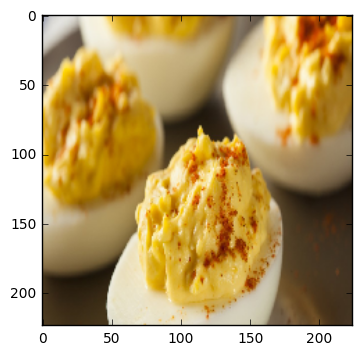

In [16]:
#img_path = 'download.jpg'  # This is an image I took in my kitchen.
j = random.randint(0,len(test_ids))
print(test_ids[j])
#img_path = 'resized_thumbs/' + test_ids[j] + '.jpg'
#img_path = 'download1.jpg'
img_path = 'rNEiQSa.png'

img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
x = np.expand_dims(img_arr, axis=0)  # The model only accepts batches so we add a dummy dimension.
x = vgg16.preprocess_input(x)  # The preprocessing should be the same that was used during training.

predictions = m.predict(x)

#label_predictions = vgg16.decode_predictions(predictions, top = 10)

conn = sqlite3.connect("yummly.db")
print(conn.execute("SELECT Title FROM Recipe WHERE ID='" + str(test_ids[j]) + "';").fetchone())
conn.close()

print('Input image size:', x.shape)


plt.imshow(np.asarray(img));

print('\nGround truth') #with Prediction')
for i in range(0,size_pantry):
    if test_labels[j][i] == 1:
        print(id2food[i])# + ": " + str(predictions[0][i]))

argsort_results = np.argsort(-predictions)[0]


# print('\nAll Predictions over 10% certainty:')
# for i in range(0,size_pantry):
#     if predictions[0][i] > 0.1:
#         print(id2food[i] + ": " + str(predictions[0][i]))

print("\nTop 10 Predictions")
for i in range(0,10):
    #print(argsort_results[i])
    print(id2food[argsort_results[i]] + ": " + str(predictions[0][argsort_results[i]]))

In [ ]:
len(predictions)

## Predicting on the entirety of the validation set, to compute precision recall curve

In [ ]:
test_predictions = np.zeros((len(test_ids), size_pantry))

for j in range(0, len(test_ids)):
    img_path = 'resized_thumbs/' + test_ids[j] + '.jpg'


    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    x = np.expand_dims(img_arr, axis=0)  # The model only accepts batches so we add a dummy dimension.
    x = vgg16.preprocess_input(x)  # The preprocessing should be the same that was used during training.

    test_predictions[j] = m.predict(x)
    
    if (j % 10000 == 0):
        print(str(j) + "...")


In [ ]:
from sklearn.metrics import average_precision_score
for i in range(0, size_pantry):
    y_true = np.array(test_labels_np[:,i])
    y_scores = np.array(test_predictions[:,i])
    print(average_precision_score(y_true, y_scores)) 

In [ ]:
pickle.dump( [test_labels_np, test_], open( "test_labels_predictions.p", "wb" ) )

In [ ]:
[test_labels_np, test_predictions] = pickle.load( open( "test_labels_predictions.p", "rb" ) )

In [ ]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(size_pantry):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_np[:, i],
                                                        test_predictions[:, i])
    average_precision[i] = average_precision_score(test_labels_np[:, i], test_predictions[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels_np.ravel(),
    test_predictions.ravel())
average_precision["micro"] = average_precision_score(test_labels_np, test_predictions,
                                                     average="micro")




In [ ]:
# Plot Precision-Recall curve
for i in range(0,size_pantry):
    plt.clf()
    plt.plot(recall[i], precision[i], lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1])
    plt.title('Precision-Recall, ' + id2food[i] + ': AUC={0:0.2f}'.format(average_precision[i]))
    plt.legend(loc="upper right")
    plt.show()

In [18]:
with open('model.json', 'w') as f:
    f.write(m.to_json())

In [ ]:
!reboot

In [ ]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         #shear_range=0.2,
#         #zoom_range=0.2,
#         horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         'images/',
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode=None)

# validation_generator = test_datagen.flow_from_directory(
#         'images/',
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode=None)

# model.fit_generator(
#         train_generator,
#         samples_per_epoch=2000,
#         nb_epoch=50,
#         validation_data=validation_generator,
#         nb_val_samples=800)